# Appendix: Guided Backprop

In [1]:
import torchinfo
from chapter import *
from torchvision import models

resnet = models.resnet18(pretrained=True)
in_features = resnet.fc.in_features
num_hidden = 256

head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.5),
    nn.Linear(in_features, num_hidden),
    nn.ReLU(),
    nn.BatchNorm1d(num_hidden),
    nn.Dropout(0.5),
    nn.Linear(num_hidden, 2),
)

model = nn.Sequential(
    nn.Sequential(*list(resnet.children())[:-2]),
    head
)

model.load_state_dict(torch.load("./artifacts/cancer_detection_model.pkl"))
model.to(DEVICE)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

To explain the outputs of convolutional networks, we can look at the effect of each
pixel in the input on each output node corresponding to a class.
That is, we consider gradients $\partial y / {\partial \boldsymbol{\mathsf{X}}^{\ell}}_{ij}$
for a target class $y$ where $\ell = 0$ for the input image.
Note that gradients can be negative in intermediate layers, so to get a stronger signal
we mask these gradients when computing backpropagation with respect to ${\boldsymbol{\mathsf{X}}^0}_{ij}$.
In effect, we backpropagate only through those neurons which cause a first-order increase
in the target class $y$. 

Moreover, positive activation indicate pattern detection for each node, hence 
we mask out nodes with negative activations further strengthening the signal.
Since this is applied to all layers, we get patterns which are compositional
and would eventually result in a positive activation for the target node.
The gradients on input pixels are calculated with these two masks in place.
This method is called **Guided Backpropagation** (GB) {cite}`allconv` used to obtain fine-grained
details in the input image that contribute to the target class.

```{figure} ../../../img/nn/03-guided_backprop.png
---
name: 03-guided_backprop
width: 100%
align: center
---
Schematic of visualizing the activations of high layer neurons. Source: Fig. 1 of {cite}`allconv`
```

In [2]:
def standardize_and_clip(x, min_val=0.0, max_val=1.0, saturation=0.1, brightness=0.5):
    x = x.detach().cpu()
    u = x.mean()
    v = max(x.std(), 1e-7)
    standardized = x.sub(u).div(v).mul(saturation)
    clipped = standardized.add(brightness).clamp(min_val, max_val)
    return clipped

def relu_hook_function(module, grad_in, grad_out):
    # Mask out negative gradients, and negative outputs
    # Note: ∂relu(x)/∂x = [x > 0] = [relu(x) > 0], 
    # so that ∂(relu input) = [relu(x) > 0] * ∂(relu output).
    # This explains why we take the gradient wrt relu input.
    return (torch.clamp(grad_in[0], min=0.),)

def resize(x):
    return transforms.Resize(size=(224, 224))(x)

def register_hooks(model):
    hooks = []
    for _, module in model.named_modules():
        if isinstance(module, torch.nn.ReLU):
            h = module.register_backward_hook(relu_hook_function)
            hooks.append(h)
    return hooks

def guided_backprop(model, x, target=None):
    hooks = register_hooks(model)

    # backward through target node
    with eval_context(model):
        p = model(x)
        if target is None:
            target = p.argmax().item()

        y = p[0, target]
        y.backward()

    g = standardize_and_clip(x.grad)
    g = g.to("cpu")
    x = x.to("cpu")
    
    # cleanup (gradients and hooks)
    for _, module in model.named_modules():
        module.zero_grad()

    for h in hooks:
        h.remove()

    return {
        "x": resize(x[0]),
        "g": resize(g[0]).max(dim=0)[0],    # <- max guided backprop! [1, H, W] map.
        "p": F.softmax(p, dim=1)[0, target]
    }   


# viz pathological tissue samples
outs = {}
target = 1
num_samples = 3
for b in range(num_samples):
    
    # prepare input image
    filepath = "data/histopathologic-cancer-detection/train"
    filename = data[data.label == target].iloc[b, 0]
    image = f"{filepath}/{filename}.tif"
    x = transform_infer(cv2.imread(image)).unsqueeze(0).to(DEVICE)
    x.requires_grad = True
    
    # magic happening...
    outs[b] = guided_backprop(model, x, target)

**Remark.** The backward 
hooks for masking negative gradients are only attached to ReLU layers 
since the network only has ReLU activations. See comments in the code. 
For other activations, you may need to implement
forward hooks to mask out negative activations. See [this video](https://www.youtube.com/watch?v=syLFCVYua6Q) on PyTorch hooks
for an introduction. 💡

Note that backward hooks are executed
before the tensor saves its gradients. 
Moreover, its return value modifies the input gradients of the given module.
Finally, we take the maximum for each input image channel 
to get a grayscale map for the gradients.

In [3]:
def normalize(x):
    """Map pixels to [0, 1]."""
    return (x - x.min()) / (x.max() - x.min())

# these can be sliders in a viz. app
min_val = 0.5
max_val = 10.0
overlay_alpha = 0.75

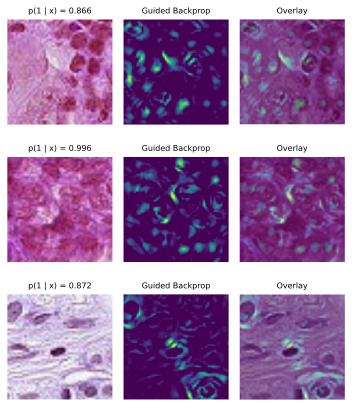

In [4]:
fig, ax = plt.subplots(num_samples, 3, figsize=(5, 6))
for b in range(num_samples):
    ax[b, 0].imshow(normalize(outs[b]["x"]).detach().permute(1, 2, 0).cpu().numpy())
    ax[b, 1].imshow(standardize_and_clip(outs[b]["g"], min_val=min_val, max_val=max_val).cpu().numpy(), cmap="viridis")
    ax[b, 2].imshow(normalize(outs[b]["x"]).detach().permute(1, 2, 0).cpu().numpy())
    ax[b, 2].imshow(standardize_and_clip(outs[b]["g"], min_val=min_val, max_val=max_val).cpu().numpy(), cmap="viridis", alpha=overlay_alpha)
    ax[b, 0].axis("off")
    ax[b, 1].axis("off")
    ax[b, 2].axis("off")
    ax[b, 0].set_title(f"p({target} | x) = {outs[b]['p']:.3f}", size=8)
    ax[b, 1].set_title("Guided Backprop", size=8)
    ax[b, 2].set_title("Overlay", size=8)

fig.tight_layout()

Not a domain expert on histopathology, but an expert on dog recognition.
Let us compare how this looks like with pretrained AlexNet on a dog image:

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image = cv2.imread("./data/shorty.png")
x = transform(image).unsqueeze(0).to(DEVICE)
x.requires_grad = True

alexnet = models.alexnet(pretrained=True).to(DEVICE)
out = guided_backprop(alexnet, x, target=None)

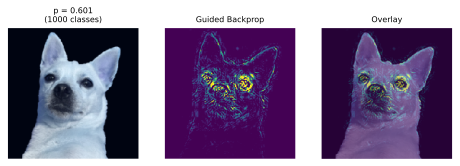

In [6]:
min_val = 0.5
max_val = 10.0
overlay_alpha = 0.75
fig, ax = plt.subplots(1, 3, figsize=(8, 10))
ax[0].imshow(normalize(out["x"]).detach().permute(1, 2, 0).cpu().numpy())
ax[1].imshow(standardize_and_clip(out["g"], min_val=min_val, max_val=max_val).cpu().numpy(), cmap="viridis")
ax[2].imshow(normalize(out["x"]).detach().permute(1, 2, 0).cpu().numpy())
ax[2].imshow(standardize_and_clip(out["g"], min_val=min_val, max_val=max_val).cpu().numpy(), cmap="viridis", alpha=overlay_alpha)
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[0].set_title(f"p = {out['p']:.3f}\n(1000 classes)", size=8)
ax[1].set_title("Guided Backprop", size=8)
ax[2].set_title("Overlay", size=8);

**Remark.** It's interesting that the model can pick out whiskers from the input image.